[异常值检测](http://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection)

# Novelty Detection新异常值检测

Novelty detection 假设训练的数据集是没有被污染的，所以会尽可能拟合训练数据集。对于新的数据，判断新数据与原始训练的数据之间匹配程度，或者由原始训练数据拟合的概率分布下，新数据对应的概率大小，以此来判断新数据是否是异常。一般通过原始训练数据，检测器能够生成一条前沿分界线，通过新进入的值是否在该线内部来判断新数据是否异常。

## svm.OneClassSVM 
OneClassSVM 适用于Novelty Detection，它需要设定一个Kernel核函数和一个scale尺度函数来决定前沿边界，一般用RBF。可以设定nu值来决定训练误差的上界；设定gamma值可以控制核函数的系数；可选的核函数有‘rbf’, ‘poly’ 和 ‘sigmoid’

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

In [2]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

In [3]:
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [4]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

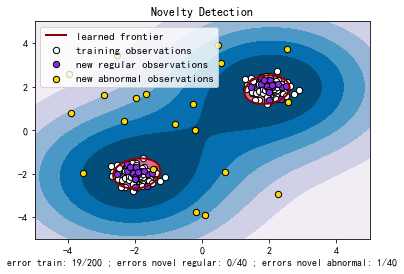

In [5]:
# plot the line, the points, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Outlier Detection异常值检测

Outlier Detection 和 Novelty Detection 很相似，不过Outlier Detection的训练数据可能是被污染过的，训练数据集中存在异常值。

## Fitting an elliptic envelope 拟合一个椭圆套

执行异常值检测的一种常见方法是假定常规数据来自已知分布 (例如, 数据是高斯分布的)。从这个假设, 我们通常试图定义的 "形状" 的数据, 并可以认为的观察足够拟合出适合的形状。

EllipticEnvelope 适用于数据的健壮的协方差估计, 因而适合一个椭圆到中央数据点, 忽略中心模式之外的点。

例如, 假设内部数据是高斯分布的, 它将以稳健的方式估计内部位置和协方差 (即不受异常值的影响)。

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [10]:
n_samples = 125
n_outliers = 25
n_features = 2

In [8]:
# generate data
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

In [11]:
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

In [12]:
# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

Automatically created module for IPython interactive environment


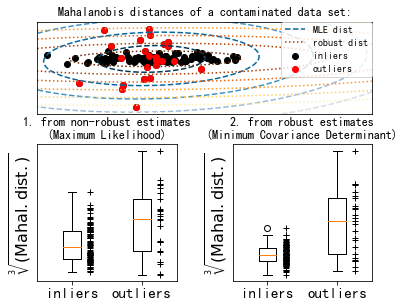

In [6]:
# #############################################################################
# Display results
fig = plt.figure()
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')

subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# Plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
subfig2 = plt.subplot(2, 2, 3)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(1.26 * np.ones(n_samples - n_outliers),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(2.26 * np.ones(n_outliers),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3 = plt.subplot(2, 2, 4)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(1.26 * np.ones(n_samples - n_outliers),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(2.26 * np.ones(n_outliers),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()

## Isolation Forest 孤立森林

在高维数据集中执行异常检测的一种有效方法是使用随机林。IsolationForest 通过随机选择一个特征, 然后随机地在所选特征的最大值和最小数值之间选择一个分割值来分离观察。

由于递归分区可以用树状结构表示, 因此隔离样本所需的分裂数等于从根节点到终止节点的路径长度。

这条路径的长度, 平均超过了森林的这种随机树, 是衡量正常和我们的决定功能。

随机分区产生明显较短的异常路径。因此, 当一个随机树的森林集体产生较短的路径长度为特定的样本, 他们很可能是异常。

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

In [36]:
# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [37]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

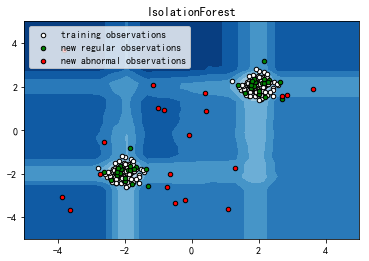

In [38]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

## Local Outlier Factor 局部异常因子

在中等高维数据集上执行异常值检测的另一种有效方法是使用局部离群因子 (LOF) 算法。

LocalOutlierFactor (LOF) 算法计算一个分数 (称为局部离群因子), 反映了观测异常的程度。它测量给定数据点与其邻域的局部密度偏差。其目的是检测比其邻密度低得多的样品。

在实践中, 局部密度是从 k 近邻得到的。观察的 LOF 评分等于他的 k 近邻的平均局部密度的比值, 以及它自己的局部密度: 一个正常的实例预计会有一个类似于它的邻域的密度, 而异常的数据将有很多更小的局部密度。

考虑的邻居数 k (别名参数 n_neighbors) 通常选择 
1. 大于群集必须包含的最小对象数, 以便其他对象可以是相对于此群集的本地异常值, 
2.  小于最大数目由可能是本地异常点的临近对象。在实践中, 这些信息通常是不可用的, 并采取 n_neighbors=20 似乎在一般工作。当异常值的比例很高 (如下面的示例中所示), n_neighbors 应该更大 (在下面的例子中 n_neighbors=35)。

LOF 算法的优点是, 它考虑了数据集的本地和全局属性: 即使在异常样本具有不同的底层密度的数据集中, 它也能表现得很好。问题不是如何孤立的样本, 而是如何孤立它是关于周围的邻里。

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

In [30]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]

In [31]:
# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

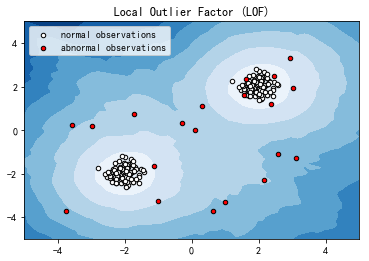

In [28]:
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

## One-class SVM versus Elliptic Envelope versus Isolation Forest versus LOF

严格来说, 一级支持向量机不是一种孤立点检测方法, 而是一种新颖的检测方法: 它的训练集不应被异常值所污染, 因为它可能适合它们。这样说, 维中的离群检测, 或者没有任何关于 inlying 数据分布的假设, 都是非常具有挑战性的, 而一级支持向量机在这些情况下提供了有用的结果。

下面的示例说明了协方差的性能。EllipticEnvelope 降低, 因为数据是越来越少的单峰。支持向量机。OneClassSVM 在具有多种模式和集成的数据方面效果更好。IsolationForest 和邻居。LocalOutlierFactor 在每种情况下都表现良好。

- 对于内部是高斯分布的单峰数据，如果训练数据存在异常值outliers， one-class svm 会受到一定的影响，Elliptic Envelope、 Isolation Forest 和 LOF表现都很好

- 对于内部是高斯分布的双峰数据， Elliptic Envelop 不能很好的拟合出合适的前沿边界线。One-class SVM 倾向于过拟合数据。Isolation Forest 和 LOF对于检测双峰都有一定困难，但LOF相对表现更好。

- 如果内部分布不是高斯分布的, 则EllipticEnvelope 完全失败。OneClassSVM 能有一个说得过去的近似。IsolationForest 和LocalOutlierFactor表现最好。